In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimize

In [4]:
class Simulation:
    def __init__(self, n, cubeSide, dimn = 3):
        '''Initialize number of particles, box size, positions and momenta'''
        self.n = n
        self.dimn = dimn
        self.cubeSide = cubeSide
        self.set_position()
        self.set_momenta_rest()
    
    def set_position(self):
        '''Randomize positions of the particle within the box'''
        # self.position = (2* np.random.random(size=(self.n, self.dimn)) - 1) * self.cubeSide
        self.position = np.random.random(size=(self.n, self.dimn)) * self.cubeSide / 50
        self.position += self.cubeSide / 2
    
    def set_momenta_rest(self):
        '''Initialize momenta to 0'''
        self.momentum = np.zeros((self.n, self.dimn))
    
    def calculate_force(self, epsilon = 1, sigma = 1):
        '''Calculate the Lennard Jones force on every particle in the system'''
        self.force = np.zeros((self.n, self.dimn))
        for i in range(self.n):
            i_pos = self.position[i]
            for j in range(i + 1, self.n):
                j_pos = self.position[j]
                r = math.dist(i_pos, j_pos)
                # ijf = -1 * (i_pos - j_pos) * (2 * np.power(sigma/r, 12) - np.power(sigma/r, 6)) / np.power(r, 2)
                ijf = (i_pos - j_pos) * (2 * np.power(sigma/r, 12) - np.power(sigma/r, 6)) / np.power(r, 2)
                # print(ijf, r)
                self.force[i] += ijf
                self.force[j] -= ijf
        self.force *= 24 * epsilon
    
    def calc_pb_force(self, epsilon = 1, sigma = 1):
        '''Calculate the Lennard Jones force on every particle in the system 
        with periodic boundary conditions'''
        self.force = np.zeros((self.n, self.dimn))
        for i in range(self.n):
            i_pos = self.position[i]
            for j in range(i + 1, self.n):
                # print(self.position)
                j_pos = self.position[j]
                for w in range(self.dimn):
                    if i_pos[w] - j_pos[w] > self.cubeSide / 2:
                        j_pos[w] += self.cubeSide
                    elif i_pos[w] - j_pos[w] < -1 * self.cubeSide / 2:
                        j_pos[w] -= self.cubeSide
                r = math.dist(i_pos, j_pos)
                # print(i, j, r)
                # ijf = -1 * (i_pos - j_pos) * (2 * np.power(sigma/r, 12) - np.power(sigma/r, 6)) / np.power(r, 2)
                ijf = (i_pos - j_pos) * (2 * np.power(sigma/r, 12) - np.power(sigma/r, 6)) / np.power(r, 2)
                # print(ijf)
                # print(ijf, r)
                self.force[i] += ijf
                self.force[j] -= ijf
        self.force *= 24 * epsilon

    def euler_integrate(self, dt, numSteps, save_n = 10, epsilon = 1, sigma = 1):
        '''Integrate the Newton's equations of motion with time step dt for numSteps and saves every save_n steps'''
        pos_list = []
        erg = []
        for i in range(numSteps):
            if i % save_n == 0:
                pos_list.append(np.copy(self.position))
                erg.append(self.potential_energy())
            self.calculate_force(epsilon, sigma)
            self.momentum += self.force * dt

            """the next line is for wrapping around the cube"""
            # self.position = (self.momentum * dt + self.position + self.cubeSide) % self.cubeSide

            """the next line is for free movement"""
            self.position = (self.momentum * dt + self.position)

            """ the next line is for bounce back """
            # self.position = (self.momentum * dt + self.position)
            # new_arr = np.logical_or(self.position <= 0, self.position >= self.cubeSide) * -2 + 1
            # self.momentum *= new_arr

        return np.array(pos_list), np.array(erg)
    
    def pb_euler_integrate(self, dt, numSteps, save_n = 10, epsilon = 1, sigma = 1):
        '''Integrate the Newton's equations of motion with time step dt for numSteps and saves every save_n steps
        with periodic boundary conditions'''
        pos_list = []
        erg = []
        for i in range(numSteps):
            if i % save_n == 0:
                pos_list.append(np.copy(self.position))
                erg.append(self.pb_potential_energy())
            self.calc_pb_force(epsilon, sigma)
            self.momentum += self.force * dt

            """the next line is for wrapping around the cube"""
            self.position = (self.momentum * dt + self.position + self.cubeSide) % self.cubeSide

            """the next line is for free movement"""
            # self.position = (self.momentum * dt + self.position)

            """ the next line is for bounce back """
            # self.position = (self.momentum * dt + self.position)
            # new_arr = np.logical_or(self.position <= 0, self.position >= self.cubeSide) * -2 + 1
            # self.momentum *= new_arr

        return np.array(pos_list), np.array(erg)

    def write_positions(self, fileName):
        '''Write current positions to the file fileName'''
        with open(fileName, 'a') as f:
            f.write(self.position)
    
    def potential_energy(self, epsilon = 1, sigma = 1):
        '''Calculate the Lennard Jones potential energy of the whole system'''
        pot = 0
        for i in range(self.n):
            i_pos = self.position[i]
            for j in range(i + 1, self.n):
                j_pos = self.position[j]
                r = math.dist(i_pos, j_pos)
                sr = np.power(sigma/r, 6)
                pot += (np.power(sr, 2) - sr)
        
        return pot * 4 * epsilon
    
    def pb_potential_energy(self, epsilon = 1, sigma = 1):
        '''Calculate the Lennard Jones potential energy of the whole system'''
        pot = 0
        # print(self.position)
        for i in range(self.n):
            i_pos = self.position[i]
            for j in range(i + 1, self.n):
                j_pos = self.position[j]
                for w in range(self.dimn):
                    if i_pos[w] - j_pos[w] > self.cubeSide / 2:
                        j_pos[w] += self.cubeSide
                    elif i_pos[w] - j_pos[w] < -1 * self.cubeSide / 2:
                        j_pos[w] -= self.cubeSide
                r = math.dist(i_pos, j_pos)
                sr = np.power(sigma/r, 6)
                pot += (np.power(sr, 2) - sr)
        
        return pot * 4 * epsilon
    
    def opt_help(self, x, epsilon = 1, sigma = 1):
        self.position = np.reshape(x, (self.n, self.dimn))
        return self.pb_potential_energy(epsilon, sigma)
    
    def minimize_potential(self):
        ans = optimize.minimize(self.opt_help, self.position)
        return np.reshape(ans.x, (self.n, self.dimn))
    
    def plot_position(self):
        for pos in self.position:
            plt.plot(pos[0], pos[1], 'o')
        


In [5]:
s = Simulation(2, 2)

In [6]:
s.position = np.array([[0,0,0],[2,0,0]])

In [7]:
num_steps = 1000
save_after_steps = 20

In [8]:
trajectory, energy = s.euler_integrate(0.01, num_steps, save_after_steps)

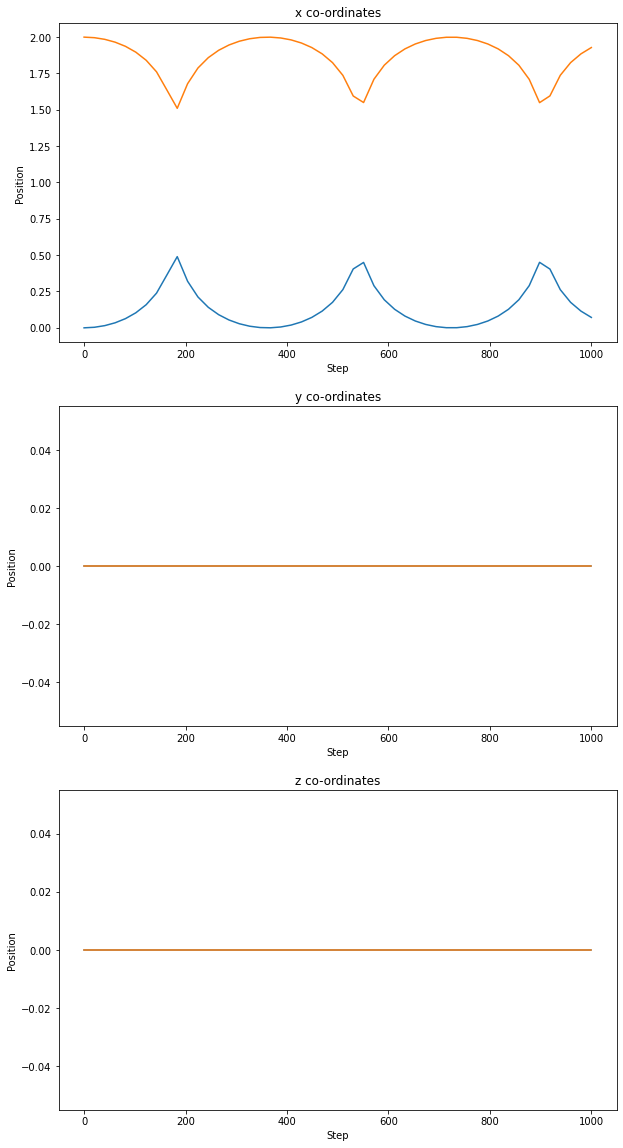

In [9]:
plt.figure(figsize=(10, 20))

c_l = ["x co-ordinates", "y co-ordinates", "z co-ordinates"]
for i in range(3):
    plt.subplot(3,1,i + 1)
    plt.plot(np.linspace(0, num_steps, int(num_steps/save_after_steps)), trajectory[:,:,i])
    plt.xlabel("Step")
    plt.ylabel("Position")
    plt.title(c_l[i])

Text(0, 0.5, 'Potential energy')

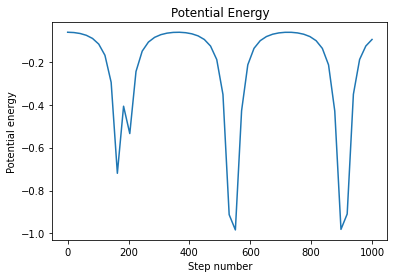

In [10]:
plt.plot(np.linspace(0, num_steps, int(num_steps/save_after_steps)), energy)
plt.title("Potential Energy")
plt.xlabel("Step number")
plt.ylabel("Potential energy")

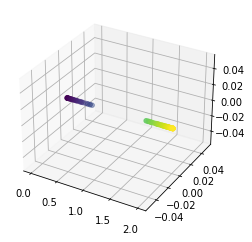

In [11]:
from mpl_toolkits import mplot3d
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
x = trajectory[:,:,0]
y = trajectory[:,:,1]
z = trajectory[:,:,2]
ax.scatter(x, y, z, c = x+y)

In [12]:
# plt.plot(trajectory[:,0,0], trajectory[:,0,1])

In [13]:
pb = Simulation(10, 1000, 2)
# pb.cubeSide = 50
# pb.position = np.array([[49, 1], [51, 1]])
pb.position

array([[502.29443555, 506.07815955],
       [505.74473939, 501.56864722],
       [509.49941503, 507.83464678],
       [514.97765148, 511.83481397],
       [500.75787725, 502.09850472],
       [518.92091448, 513.200854  ],
       [501.88936606, 508.14455732],
       [505.25100669, 511.08742365],
       [512.11350471, 509.70298084],
       [504.74824807, 515.86699118]])

In [14]:
num_steps = 10000
save_after_steps = 1
pb_traj, pb_en = pb.pb_euler_integrate(0.01, num_steps, save_after_steps)

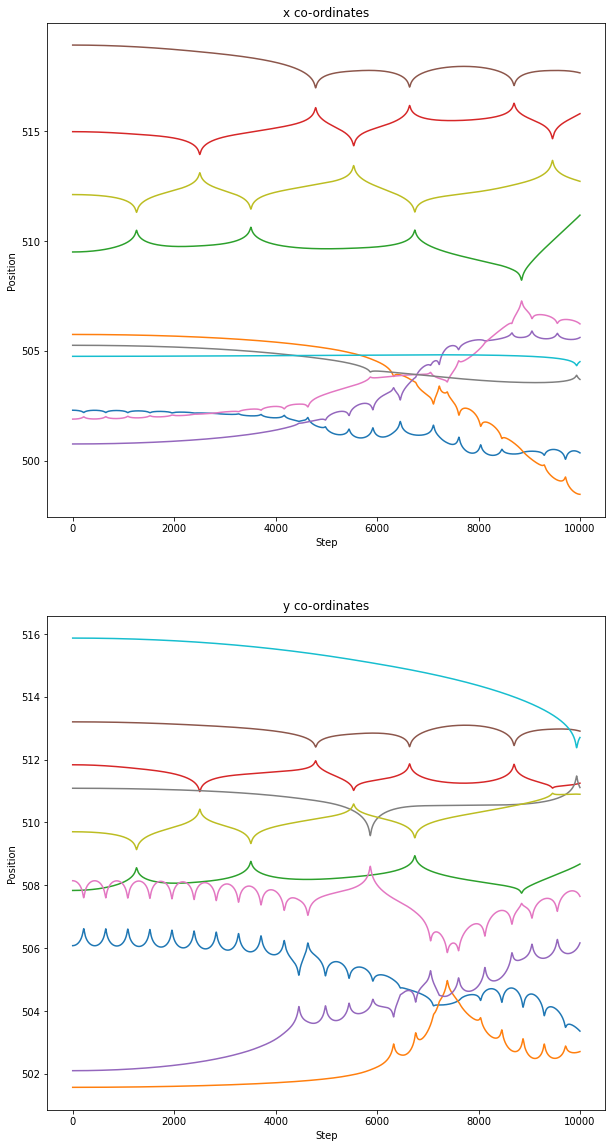

In [15]:
plt.figure(figsize=(10, 20))

# c_l = ["x co-ordinates", "y co-ordinates", "z co-ordinates"]
for i in range(pb.dimn):
    plt.subplot(pb.dimn,1,i + 1)
    plt.plot(np.linspace(0, num_steps, int(num_steps/save_after_steps)), pb_traj[:,:,i])
    plt.xlabel("Step")
    plt.ylabel("Position")
    plt.title(c_l[i])

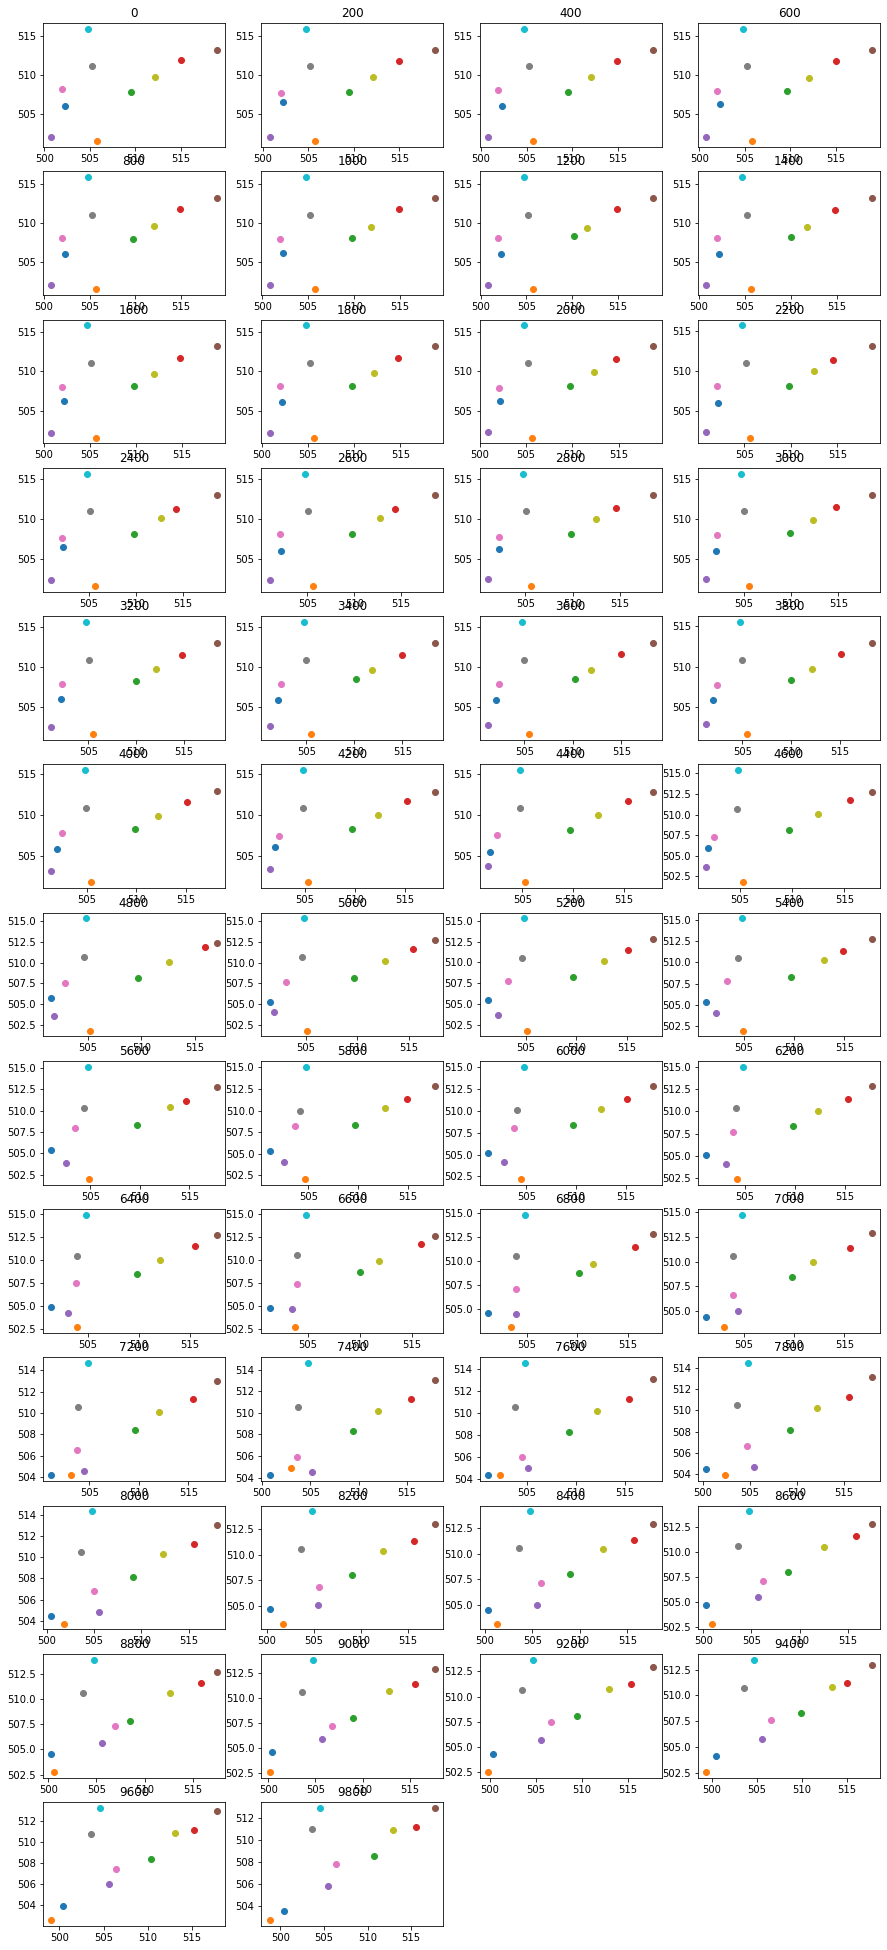

In [16]:
plt.figure(figsize=(15, 35))
k = 1
a= 0
for i in pb_traj[::int(num_steps/(save_after_steps*50))]:
    plt.subplot(13, 4, k)
    for j in i:
        plt.plot(j[0], j[1], 'o')
    k+=1
    plt.title(str(a))
    a+=int(num_steps/(save_after_steps*50))
    # plt.xlim([0,pb.cubeSide])
    # plt.ylim([0,pb.cubeSide])

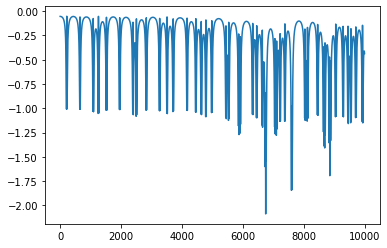

In [17]:
plt.plot(range(0,num_steps, save_after_steps), pb_en)

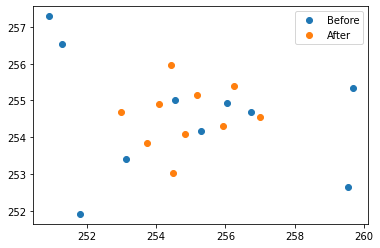

In [18]:
vs = Simulation(10, 500, 2)
plt.plot(vs.position[:,0], vs.position[:,1], 'o', label='Before')
ans = vs.minimize_potential()
plt.plot(ans[:,0], ans[:,1], 'o', label='After')
plt.legend()

In [19]:
class MC_Simulation:
    def __init__(self, n, cubeSide, dimn = 3):
        '''Initialize number of particles, box size, positions and momenta'''
        self.n = n
        self.dimn = dimn
        self.cubeSide = cubeSide
        self.set_position()
    
    def set_position(self):
        '''Randomize positions of the particle within the box'''
        self.position = np.random.random(size=(self.n, self.dimn)) * self.cubeSide
    
    def mc_move(self):
        new_pos = self.mc_suggest()
        self.mc_metropolis(new_pos)
    
    def mc_suggest(self):
        to_move = np.random.randint(self.n)
        new_pos = np.copy(self.position)
        new_pos[to_move] = (np.random.random(size=(self.dimn)) * 2 - 1 + new_pos[to_move] + self.cubeSide) % self.cubeSide
        return new_pos

    def mc_metropolis(self, new_pos, beta = 1):
        del_u = self.potential_energy(new_pos) - self.potential_energy(self.position)
        p = min(1, np.exp(-1 * beta * del_u))
        if np.random.random() < p:
            self.position = new_pos

    def potential_energy(self, pos, epsilon = 1, sigma = 1):
        '''Calculate the Lennard Jones potential energy of the whole system'''
        pot = 0
        for i in range(self.n):
            i_pos = pos[i]
            for j in range(i + 1, self.n):
                j_pos = pos[j]
                r = math.dist(i_pos, j_pos)
                sr = np.power(sigma/r, 6)
                pot += (np.power(sr, 2) - sr)
        
        return pot * 4 * epsilon

    def trajectory(self, numSteps, save_n = 10):
        traj = []

        for step in range(numSteps):
            if step % save_n == 0:
                traj.append(np.copy(self.position))
            self.mc_move()
        
        return np.array(traj)

In [20]:
mcs = MC_Simulation(10, 5, 2)
traj = mcs.trajectory(1000, 20)


<ipython-input-19-5c52e0e3a5ee>:25: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(-1 * beta * del_u))


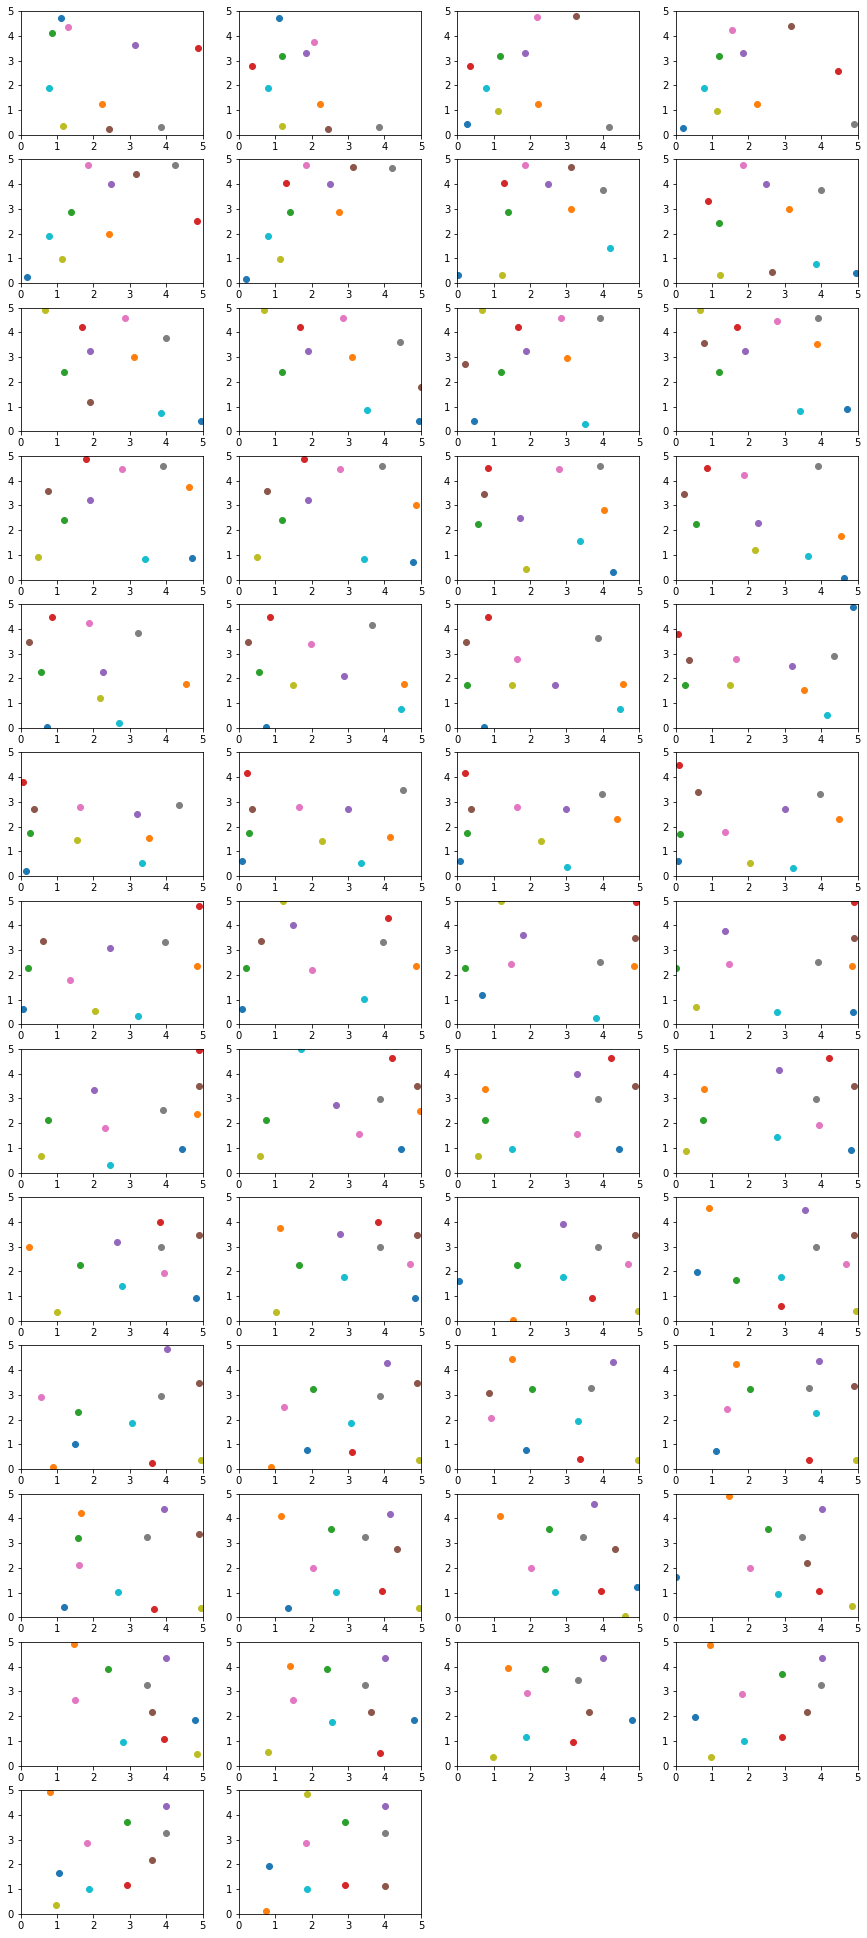

In [23]:
plt.figure(figsize=(15, 35))
k = 1
a= 0
for i in traj:
    plt.subplot(13, 4, k)
    for j in i:
        plt.plot(j[0], j[1], 'o')
    k+=1
    plt.xlim([0,5])
    plt.ylim([0,5])